Parte 2
===

In [1]:
import warnings as ws
ws.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:,.2f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
%matplotlib inline

from sklearn.ensemble import IsolationForest

## Procedimientos de limpieza y estandarización

In [2]:
# Procedimientos de limpieza, estandarización y construcción de características

def build_age_ranges(value, ranges):
    range_ = None
    for r in ranges:
        if value in r:
            range_ = r
            break
    return range_

def build_user_profile(value):
    if value == 1:
        return 'Usuario en quiebra'
    elif value == 7:
        return 'Joven'
    elif value >= 150 and value < 400:
        return 'Bajo'
    elif value >= 400 and value < 700:
        return 'Medio'
    elif value >= 700:
        return 'Alto'
    else:
        return 'Sin registro'
        
def clean_build_data(data_df):
    # Eliminamos las características que no serán requeridas
    no_missing_columns = None
    with open('output/columns_no_missing.pkl', 'rb') as f:
        no_missing_columns = pickle.load(f)
    data_df = data_df[no_missing_columns]

    # Reemplazamos valores negativos en características numéricas por NULO
    # y luego los valores nulos por cero (0)
    types_temp = data_df.dtypes.astype(str)
    columns_temp = types_temp[types_temp.isin(['int64', 'float64'])].index.tolist()
    columns_temp_zeros = [i for i in columns_temp if i not in ['edad', 'Promedio de cantidad_cuotas']]
    for column in columns_temp:
        data_df[column] = data_df[column].apply(lambda x: np.nan if x < 0 else x)
    for column in columns_temp_zeros:
        data_df[column] = data_df[column].fillna(0)
        
    # Reemplazamos nulos en genero por OTRO
    data_df['genero'] = data_df['genero'].fillna('OTRO')
    
    # Imputamos edad con su media
    age_imputer = 31
    data_df['edad'] = data_df['edad'].fillna(age_imputer)
    
    # Imputamos Promedio de cantidad_cuotas con su mediana
    amount_fees_imputer = 3.2
    data_df['Promedio de cantidad_cuotas'] = data_df['Promedio de cantidad_cuotas'].fillna(amount_fees_imputer)

    # Creamos variable rango de edad
    age_ranges = None
    with open('output/age_ranges.pkl', 'rb') as f:
        age_ranges = pickle.load(f)
    
    data_df['rango_edad'] = data_df['edad'].apply(
        lambda x: build_age_ranges(x, age_ranges)
    ).astype(str)
    data_df = data_df.drop(columns=['edad'])
    
    # Estandarizamos variable Genero
    genero_map = {
        'MASCULINO': 'MASCULINO',
        'FEMENINO': 'FEMENINO',
        'OTRO': 'OTRO',
        'DESCONOCIDO': 'OTRO',
        'OMITIDO': 'OTRO',
    }
    data_df['genero'] = data_df['genero'].map(genero_map)
    
    # Estandarizamos variable Antiguedad
    antiquity_map = {
        'Menos de 6 meses': 'Menos de 6 meses',
        'de 6 meses a 1 año': '6 meses o mas',
        'mas de 1 año': '6 meses o mas',
    }
    data_df['Antiguedad'] = data_df['Antiguedad'].map(antiquity_map)
    
    # Estandarizamos variable mop historico
    mop_map = {
        'N': 'Al día',
        '1': 'Mora 30 a 120 días',
        '2': 'Mora 30 a 120 días',
        '3': 'Mora 30 a 120 días',
        '4': 'Mora 30 a 120 días',
        '5': 'Mora > 120 días',
        '6': 'Mora > 120 días',
    }
    data_df['mop_historico'] = data_df['mop_historico'].map(mop_map)
    data_df['mop_historico'] = data_df['mop_historico'].fillna('Sin registro')

    # Construimos variable perfil de usuario
    data_df['perfil_usuario'] = data_df['score'].apply(build_user_profile)
    data_df = data_df.drop(columns=['score'])
    
    # Convertimos Garantia en categorica
    garantia_map = {
        0.0: 'Sin garantia',
        1.0: 'Tipo garantia 1',
        2.0: 'Tipo garantia 2',
    }
    data_df['Garantia'] = data_df['Garantia'].map(garantia_map)
    data_df['Garantia'] = data_df['Garantia'].fillna('Sin garantia')
    
    return data_df

In [3]:
# Procedimiento de homologación tipos de dato y conversión de categoricas

target_column = ['Y']

def standardize_data_types(data_df):
    types_temp = data_df.dtypes.astype(str)
    categorical_columns = types_temp[types_temp.isin(['object'])].index.tolist()
    numerical_columns = types_temp[types_temp.isin(['int64', 'float64'])].index.tolist()
    numeric_int_columns = ['Creditos', 'Promedio de cantidad_cuotas', 'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto',
                       'Tiene_ahorro', 'Comunicaciones_pagos_vencidos', 'consumo_pagos_vencidos']

    for i, column in enumerate(numeric_int_columns):
        data_df[column] = data_df[column].astype('int64')
    
    return data_df, categorical_columns, numerical_columns

def get_dummies_fields(data_df, categorical_columns):
    return pd.get_dummies(data_df, columns=categorical_columns)

## 1. Carga de la base de datos

In [4]:
df = pd.read_csv('data/Perfilador_Reparadora.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

df.shape

(50000, 80)

### Aplicamos la regla de negocio saldo actual > 4.500.000

In [5]:
df.saldo_actual.describe()

count          50,000.00
mean       33,561,800.17
std        67,898,139.51
min         4,500,000.00
25%         7,815,000.00
50%        16,778,000.00
75%        39,212,250.00
max     6,082,201,976.00
Name: saldo_actual, dtype: float64

Según el reporte anterior, los datos ya se encuentran filtrados por **saldo_actual** mayores o iguales que **$4.500.000**

## 2. Aplicación procedimientos sobre variables

In [9]:
result_df = df.copy()
result_df.shape

(50000, 80)

In [10]:
# Limpieza de los datos

result_df = clean_build_data(result_df)
result_df = result_df.dropna(how='all', axis=0)
result_df = result_df.fillna(0, axis=0)
result_df.shape

(50000, 25)

In [11]:
# Estandarización y homologación

result_df, categorical_columns, numerical_columns = standardize_data_types(result_df)
result_df = get_dummies_fields(result_df, categorical_columns)

result_df.shape

(50000, 41)

In [12]:
# Cargamos el objeto con las columnas relevantes para entrenamiento

model_columns = None

with open('output/columns.pkl', 'rb') as f:
    model_columns = pickle.load(f)
    
model_columns.shape

(14,)

In [13]:
# Ajustamos el conjunto de datos nuevo a las columnas faltantes del conjunto con que se entreno
# Se imputan los valores con cero

for col in [i for i in model_columns if i not in result_df.columns]:
    result_df[col] = 0

result_df.shape

(50000, 41)

In [14]:
X = result_df[model_columns].reset_index(drop=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Creditos                       50000 non-null  int64  
 1   saldo_actual                   50000 non-null  int64  
 2   saldo_vencido                  50000 non-null  float64
 3   Promedio de limite_credito     50000 non-null  float64
 4   Promedio de credito_maximo     50000 non-null  float64
 5   Promedio de cantidad_cuotas    50000 non-null  int64  
 6   Promedio de valor_cuota        50000 non-null  float64
 7   coaching_impacto               50000 non-null  int64  
 8   Comunicaciones_saldo_actual    50000 non-null  float64
 9   Comunicaciones_pagos_vencidos  50000 non-null  int64  
 10  Consumo_saldo_actual           50000 non-null  float64
 11  perfil_usuario_Alto            50000 non-null  uint8  
 12  perfil_usuario_Joven           50000 non-null 

## 3. Aplicación modelo en nuevas observaciones

In [15]:
with open('output/model.pkl', 'rb') as f:
    model = pickle.load(f)
    
model

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(random_state=0),
                          random_state=0)

In [16]:
pred_y = model.predict(X)

pd.Series(pred_y).value_counts()

1    49175
0      825
dtype: int64

<AxesSubplot:ylabel='count'>

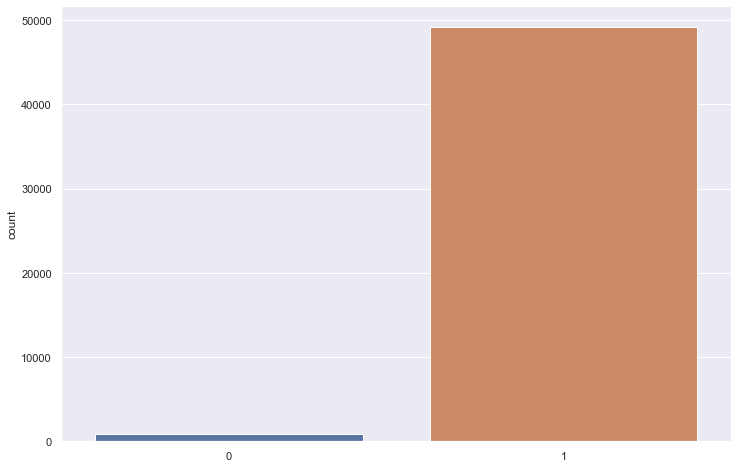

In [17]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x=pred_y, ax=ax)

## 4. Construcción variable de particionamiento
Vamos a tomar todos los usuarios marcados como **Rechazados** y los vamos a eliminar, asumiendo que el modelo tiene una calidad bastante aceptable para descartar.

In [18]:
final_df = X.copy()
final_df['Y'] = pred_y
final_df = final_df[final_df.Y == 1]
final_df = final_df.drop(columns='Y')

final_df.to_csv('data/result.csv', sep=";", encoding="utf-8", index=False)

final_df.shape

(49175, 14)

In [19]:
final_df.columns

Index(['Creditos', 'saldo_actual', 'saldo_vencido',
       'Promedio de limite_credito', 'Promedio de credito_maximo',
       'Promedio de cantidad_cuotas', 'Promedio de valor_cuota',
       'coaching_impacto', 'Comunicaciones_saldo_actual',
       'Comunicaciones_pagos_vencidos', 'Consumo_saldo_actual',
       'perfil_usuario_Alto', 'perfil_usuario_Joven',
       'perfil_usuario_Sin registro'],
      dtype='object')

In [20]:
final_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Creditos,"49,175.00",1.64,1.19,1.00,1.00,1.00,2.00,26.00
saldo_actual,"49,175.00","33,710,325.34","68,336,864.10","4,500,000.00","7,863,500.00","16,843,000.00","39,381,500.00","6,082,201,976.00"
saldo_vencido,"49,175.00","3,202,049.68","16,762,885.98",0.00,0.00,0.00,0.00,"1,608,429,952.00"
Promedio de limite_credito,"49,175.00","1,031,109.77","3,531,293.81",0.00,0.00,0.00,0.00,"101,900,000.00"
Promedio de credito_maximo,"49,175.00","18,864,845.65","23,789,915.44",0.00,"6,233,333.33","11,666,666.67","24,000,000.00","835,961,274.91"
Promedio de cantidad_cuotas,"49,175.00",62.90,55.15,0.00,30.00,60.00,78.00,592.00
Promedio de valor_cuota,"49,175.00","1,562,227.66","5,817,381.15",0.00,"250,000.00","404,333.33","746,500.00","339,129,984.00"
coaching_impacto,"49,175.00",0.00,0.07,0.00,0.00,0.00,0.00,1.00
Comunicaciones_saldo_actual,"49,175.00",975.17,"77,557.96",0.00,0.00,0.00,0.00,"7,896,000.00"
Comunicaciones_pagos_vencidos,"49,175.00",0.00,0.13,0.00,0.00,0.00,0.00,14.00


Notese que algunas variables tienen varianzas muy altas. Esto puede indicar que pueden haber errores en el conjunto de datos o que existen usuarios que se salen un poco de los rangos normales. Cualquiera que sea el motivo, vamos a revisar estos datos y a clasificar el conjunto de datos con una variable agrupadora.

**NOTA IMPORTANTE:** De este punto en adelente no se tendrá en cuenta, ya que fue un intento de detectar valores atípicos y hacer un cluster de usuarios con dicho procesamiento. Realizaremos primero el modelado de Clustering y regresaremos a este enfoque si es necesario.

In [21]:
outliers_columns = ['saldo_actual', 'saldo_vencido', 'Promedio de credito_maximo', 'Consumo_saldo_actual']

final_df[outliers_columns].describe(percentiles=[0.05, 0.1, 0.25, 0.75, 0.9, 0.95])

,saldo_actual,saldo_vencido,Promedio de credito_maximo,Consumo_saldo_actual
count,"49,175.00","49,175.00","49,175.00","49,175.00"
mean,"33,710,325.34","3,202,049.68","18,864,845.65","17,365,392.21"
std,"68,336,864.10","16,762,885.98","23,789,915.44","41,127,608.45"
min,"4,500,000.00",0.00,0.00,0.00
5%,"4,910,000.00",0.00,0.00,0.00
10%,"5,382,000.00",0.00,0.00,0.00
25%,"7,863,500.00",0.00,"6,233,333.33",0.00
50%,"16,843,000.00",0.00,"11,666,666.67","7,569,000.00"
75%,"39,381,500.00",0.00,"24,000,000.00","19,692,500.00"
90%,"76,437,800.00","7,114,600.00","42,765,600.00","42,931,200.00"


Según lo anterior, en el percentil **95%** se intuye que los datos tienen una varianza adecuada. Por tanto, definimos este percentil para decidir factores de contaminación en procesamiento de outliers.

Vamos a ejecutar la técnica de **detección de anomalías Isolation Forest**, la cual, al igual que Local Outlier Factor es bastante robusta, pero tiene mucha mejor eficiencia, además, usa algoritmos de árboles aleatorios para encontrar valores muy a los extremos. El factor de contaminación será **auto**, ya que el mismo algoritmo decide los extremos.

In [22]:
clf = IsolationForest(random_state=0, contamination='auto')
outliers_mark = clf.fit_predict(final_df)

final_isolation_df = final_df.copy()
final_isolation_df['outlier'] = pd.Series(outliers_mark).apply(lambda x: 1 if x == -1 else 0)
final_isolation_df.outlier.value_counts()

0.00    43728
1.00     4638
Name: outlier, dtype: int64

In [23]:
final_isolation_df[final_isolation_df.outlier == 0][outliers_columns].describe()

,saldo_actual,saldo_vencido,Promedio de credito_maximo,Consumo_saldo_actual
count,"43,728.00","43,728.00","43,728.00","43,728.00"
mean,"33,631,757.24","3,214,732.44","18,844,004.58","17,330,986.37"
std,"69,532,074.70","17,183,267.91","23,645,428.48","41,576,857.04"
min,"4,500,000.00",0.00,0.00,0.00
25%,"7,851,750.00",0.00,"6,226,000.00",0.00
50%,"16,885,000.00",0.00,"11,665,833.33","7,574,000.00"
75%,"39,460,500.00",0.00,"24,000,000.00","19,738,500.00"
max,"6,082,201,976.00","1,608,429,952.00","835,961,274.91","3,776,354,064.00"


In [24]:
final_isolation_df[final_isolation_df.outlier == 1][outliers_columns].describe()

,saldo_actual,saldo_vencido,Promedio de credito_maximo,Consumo_saldo_actual
count,"4,638.00","4,638.00","4,638.00","4,638.00"
mean,"34,057,426.47","3,152,114.06","18,785,934.05","17,447,110.82"
std,"57,872,756.22","13,166,235.58","23,215,544.97","36,841,684.06"
min,"4,500,000.00",0.00,0.00,0.00
25%,"7,966,000.00",0.00,"6,282,000.00",0.00
50%,"16,457,500.00",0.00,"11,620,625.00","7,470,000.00"
75%,"37,585,500.00",0.00,"23,619,250.00","19,149,000.00"
max,"1,326,580,008.00","221,180,992.00","374,106,000.00","753,604,992.00"


<AxesSubplot:xlabel='outlier', ylabel='Consumo_saldo_actual'>

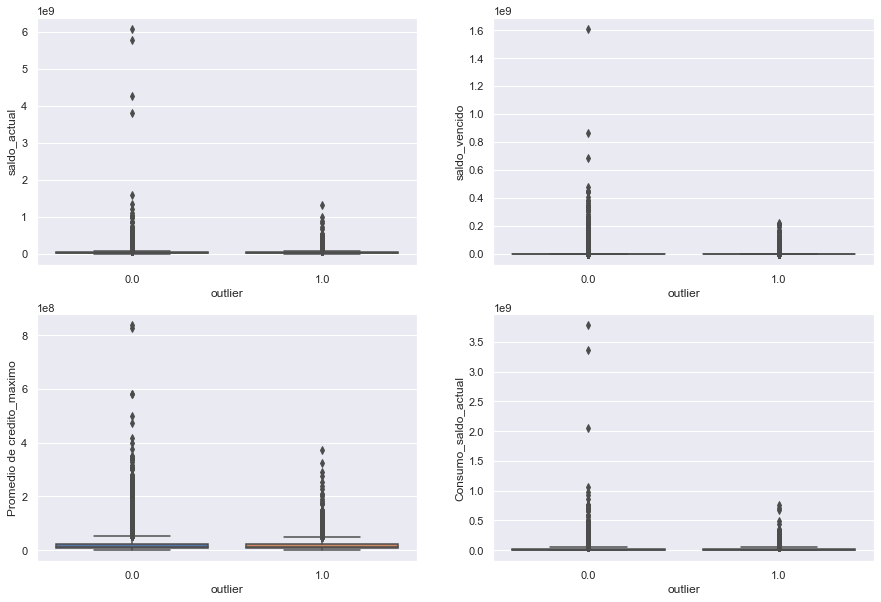

In [25]:
temp_data = final_isolation_df[outliers_columns]

f, ax = plt.subplots(figsize=(15, 10), ncols=2, nrows=2)
sns.boxplot(x=final_isolation_df.outlier, y=temp_data['saldo_actual'], ax=ax[0][0])
sns.boxplot(x=final_isolation_df.outlier, y=temp_data['saldo_vencido'], ax=ax[0][1])
sns.boxplot(x=final_isolation_df.outlier, y=temp_data['Promedio de credito_maximo'], ax=ax[1][0])
sns.boxplot(x=final_isolation_df.outlier, y=temp_data['Consumo_saldo_actual'], ax=ax[1][1])

Dado que el resultado nos sigue dejando un conjunto de valores con mucha varianza em ambos conjuntos de datos, realizaremos una marcación manual considerando el percentil donde se comienzan a notar los valores más alejados para cada variable, en este caso, por encima del percentil **95%**.

In [26]:
outliers_desc = pd.DataFrame(final_df[outliers_columns].describe(percentiles=[0.05, 0.1, 0.25, 0.75, 0.9, 0.95]))
outliers_desc = outliers_desc.loc['95%']
outliers_desc

saldo_actual                 109,482,600.00
saldo_vencido                 16,198,100.00
Promedio de credito_maximo    57,600,000.00
Consumo_saldo_actual          66,386,800.00
Name: 95%, dtype: float64

In [27]:
def get_outlier_flag(row):
    for col in outliers_columns:
        if row[col] >= outliers_desc[col]:
            return 1
    return 0

final_outlier_df = final_df.copy()
final_outlier_df['outlier'] = final_outlier_df.apply(get_outlier_flag, axis=1)

final_df.shape, final_outlier_df.shape

((49175, 14), (49175, 15))

In [28]:
# Inliers
final_outlier_df[final_outlier_df.outlier == 0][outliers_columns].describe()

,saldo_actual,saldo_vencido,Promedio de credito_maximo,Consumo_saldo_actual
count,"42,340.00","42,340.00","42,340.00","42,340.00"
mean,"21,633,084.10","947,395.96","13,941,389.17","10,982,895.37"
std,"19,936,546.49","2,735,000.58","12,207,263.34","13,274,998.37"
min,"4,500,000.00",0.00,0.00,0.00
25%,"7,130,000.00",0.00,"5,860,000.00",0.00
50%,"13,848,500.00",0.00,"10,027,000.00","6,698,500.00"
75%,"29,278,000.00",0.00,"19,556,250.00","15,337,500.00"
max,"109,482,000.00","16,196,000.00","57,599,000.00","66,385,000.00"


In [29]:
# Outliers
final_outlier_df[final_outlier_df.outlier == 1][outliers_columns].describe()

,saldo_actual,saldo_vencido,Promedio de credito_maximo,Consumo_saldo_actual
count,"6,835.00","6,835.00","6,835.00","6,835.00"
mean,"108,523,843.07","17,168,697.58","49,363,623.56","56,902,322.16"
std,"156,966,346.79","41,820,568.14","45,482,471.14","96,246,956.14"
min,"4,500,000.00",0.00,0.00,0.00
25%,"45,849,000.00",0.00,"20,000,000.00","7,272,000.00"
50%,"82,849,000.00",0.00,"39,521,000.00","36,121,000.00"
75%,"131,461,500.00","23,296,500.00","66,000,000.00","80,710,000.00"
max,"6,082,201,976.00","1,608,429,952.00","835,961,274.91","3,776,354,064.00"


<AxesSubplot:xlabel='outlier', ylabel='Consumo_saldo_actual'>

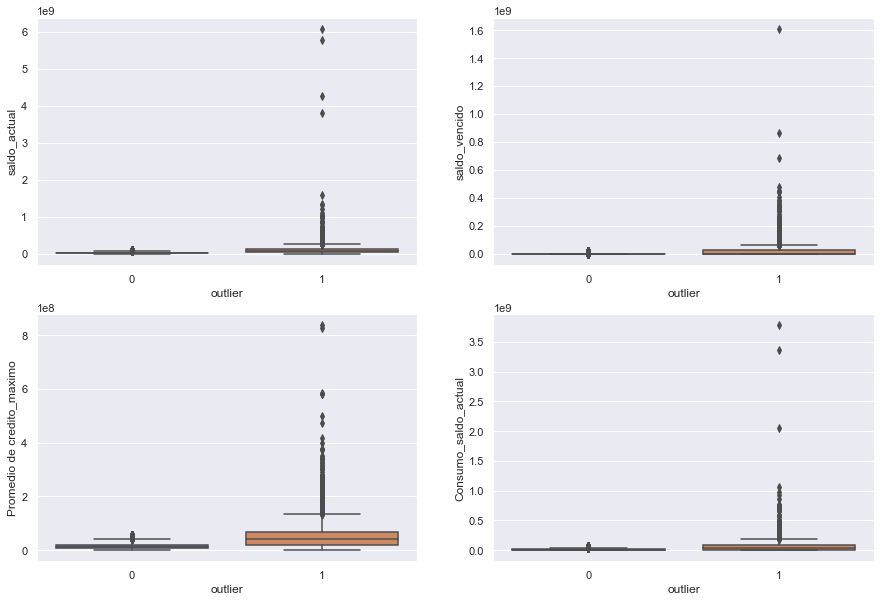

In [30]:
temp_data = final_outlier_df[outliers_columns]

f, ax = plt.subplots(figsize=(15, 10), ncols=2, nrows=2)
sns.boxplot(x=final_outlier_df.outlier, y=temp_data['saldo_actual'], ax=ax[0][0])
sns.boxplot(x=final_outlier_df.outlier, y=temp_data['saldo_vencido'], ax=ax[0][1])
sns.boxplot(x=final_outlier_df.outlier, y=temp_data['Promedio de credito_maximo'], ax=ax[1][0])
sns.boxplot(x=final_outlier_df.outlier, y=temp_data['Consumo_saldo_actual'], ax=ax[1][1])

In [31]:
final_df.shape, final_outlier_df.shape

((49175, 14), (49175, 15))

## 5. Almacenamiento resultados de predicción

In [30]:
# final_outlier_df.to_csv('data/result.csv', sep=";", encoding="utf-8", index=False)